In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')

import cv2 
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

# Mini EDA

(808, 1247, 3)


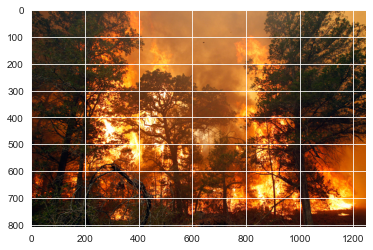

In [2]:
#visualizing a sample of the fire image
imgpath = "./forest fire/fire/COMEX-default.jpg"
img = plt.imread(imgpath)
print (img.shape)
imshow(img)

(1080, 1920, 3)


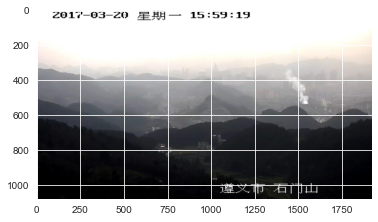

In [3]:
#visualizing a sample of the smoke image
imgpath = "./forest fire/smoke/000034.jpg"
img = plt.imread(imgpath)
print (img.shape)
imshow(img)

# Read Images

In [4]:
filepaths = []
labels = []
fire_dir= "./forest fire/fire"
smoke_dir = "./forest fire/smoke"

for d in [smoke_dir, fire_dir]:
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join(d,f)
        filepaths.append(fpath)
        if d== smoke_dir:
            labels.append('smoke')
        else:
            labels.append('fire')
            
print ('Total number of images: ', len(labels))

Total number of images:  13733


## Add files to dataframe

In [5]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

In [6]:
df = pd.concat([Fseries, Lseries], axis=1)
df.head()

,filepaths,labels
0,./forest fire/smoke\000001.jpg,smoke
1,./forest fire/smoke\000002.jpg,smoke
2,./forest fire/smoke\000003.jpg,smoke
3,./forest fire/smoke\000004.jpg,smoke
4,./forest fire/smoke\000005.jpg,smoke


In [7]:
df['labels'].value_counts()

smoke    12631
fire      1102
Name: labels, dtype: int64

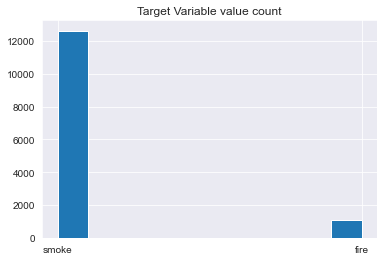

In [8]:
df['labels'].hist()
plt.title('Target Variable value count')
plt.show()

# Feature Selection and Preprocessing

## Create train, test, valid dataframes and generators

In [9]:
height=200
width=400
channels=3
batch_size=80
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.9
test_split=.05

In [10]:
dummy_split = test_split/(1-train_split)
train_df, dummy_df = train_test_split(df, train_size = train_split, shuffle = True, random_state = 123)
test_df, valid_df = train_test_split(dummy_df, 
                                     train_size = dummy_split, 
                                     shuffle = True, 
                                     random_state = 123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))

train samples:  12359   test samples:  687  validation samples 687


In [11]:
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]

test_steps = int(length/test_batch_size)
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  3   test steps:  229


In [12]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                 shear_range = 0.2,
                                 zoom_range = 0.2,
                                 horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [13]:
train_gen = train_datagen.flow_from_dataframe(train_df, 
                                    x_col = 'filepaths', 
                                    y_col = 'labels', 
                                    target_size = img_size, 
                                    class_mode = 'categorical',
                                    color_mode = 'rgb', 
                                    shuffle = False, 
                                    batch_size = batch_size)

test_gen = test_datagen.flow_from_dataframe(test_df,  
                                     x_col = 'filepaths', 
                                     y_col = 'labels', 
                                     target_size = img_size, 
                                     class_mode = 'categorical',
                                     color_mode = 'rgb', 
                                     shuffle = False, 
                                     batch_size = test_batch_size)

valid_gen = train_datagen.flow_from_dataframe(valid_df,  
                                      x_col = 'filepaths', 
                                      y_col = 'labels', 
                                      target_size = img_size, 
                                      class_mode = 'categorical',
                                      color_mode = 'rgb', 
                                      shuffle = False, 
                                      batch_size = batch_size)

Found 12359 validated image filenames belonging to 2 classes.
Found 687 validated image filenames belonging to 2 classes.
Found 687 validated image filenames belonging to 2 classes.


In [14]:
label_counts = np.sum(train_gen.labels, axis=0)
label_counts

11364

In [15]:
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = int(len(train_gen.labels)/batch_size)

# More EDA

In [16]:
# Create a list of class names
class_names = list(train_gen.class_indices.keys())
class_names

['fire', 'smoke']

In [17]:
train_gen.class_indices

{'fire': 0, 'smoke': 1}

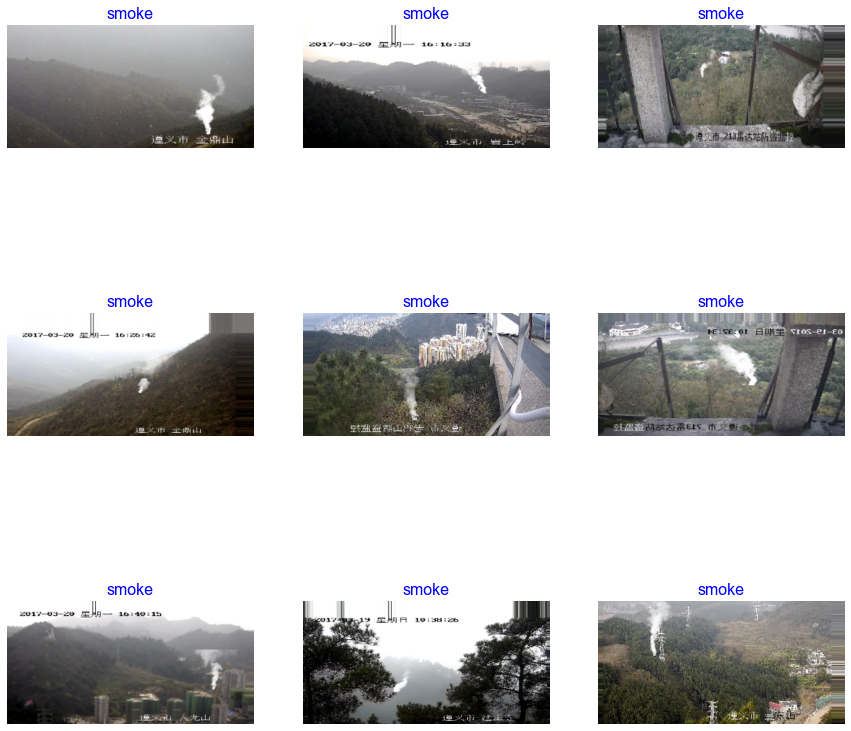

In [18]:
plt.figure(figsize=(15, 15))
images, labels = next(train_gen)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    index = np.argmax(labels[i])
    plt.title(class_names[index], color='blue', fontsize=16)
    plt.axis("off") 

# Base

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation='sigmoid')
])

In [20]:
# Compile the model
model.compile(
    optimizer = Adam(),  # Use the Adam optimizer
    loss = "binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics = ["accuracy"]  # Monitor the accuracy during training
)

In [21]:
# Train the model
history = model.fit(
    train_gen,  # Pass the training data
    validation_data = valid_gen,
    epochs=10,  # Set the number of epochs to train for
    batch_size=batch_size # Add batch size parameter
)

Epoch 1/10
155/155 [==============================] - 1532s 10s/step - loss: 0.1174 - accuracy: 0.9688 - val_loss: 0.0119 - val_accuracy: 0.9971
Epoch 2/10
155/155 [==============================] - 1314s 8s/step - loss: 0.0301 - accuracy: 0.9923 - val_loss: 0.0098 - val_accuracy: 0.9956
Epoch 3/10
155/155 [==============================] - 1335s 9s/step - loss: 0.0162 - accuracy: 0.9948 - val_loss: 0.1816 - val_accuracy: 0.9461
Epoch 4/10
155/155 [==============================] - 1332s 9s/step - loss: 0.0179 - accuracy: 0.9947 - val_loss: 0.0190 - val_accuracy: 0.9942
Epoch 5/10
155/155 [==============================] - 1314s 8s/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0286 - val_accuracy: 0.9942
Epoch 6/10
155/155 [==============================] - 1292s 8s/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 4.1078e-04 - val_accuracy: 1.0000
Epoch 7/10
155/155 [==============================] - 1309s 8s/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 3.4178e-04 - val_

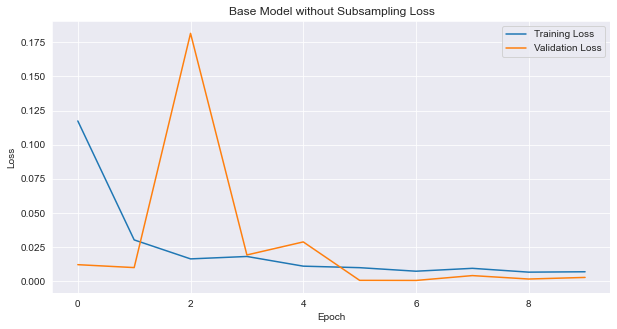

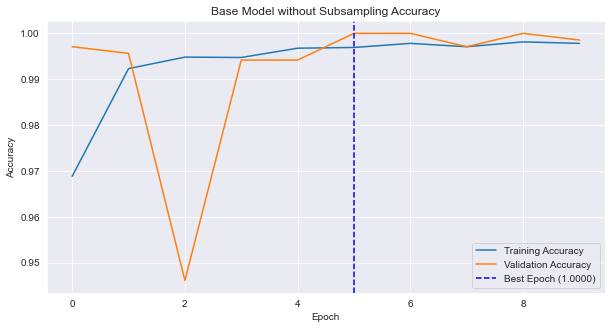

In [22]:
def plot_history(title, history):
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    # Find the index of the epoch with the best validation accuracy
    best_epoch = val_acc.index(max(val_acc))

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Highlight the overall best epoch
    best_val_acc = max(val_acc)
    plt.axvline(x=val_acc.index(best_val_acc), color='blue', linestyle='--', label=f'Best Epoch ({best_val_acc:.4f})')

    plt.legend()
    plt.show()

plot_history('Base Model without Subsampling', history)

## Evaluate

230/230 [==============================] - 38s 163ms/step


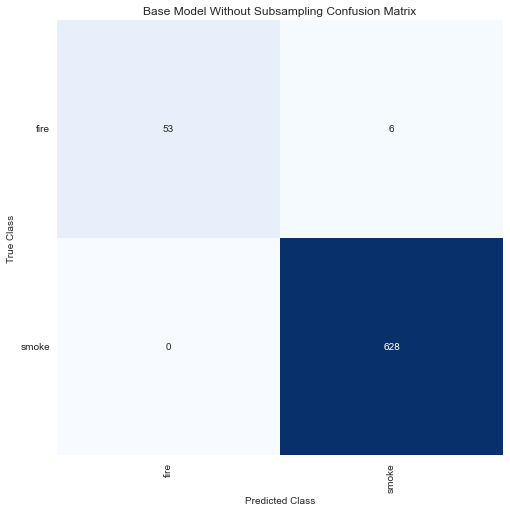

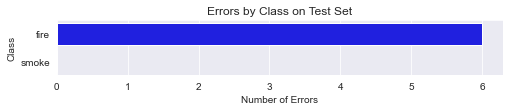

In [23]:
def plot_confusion_matrix(model, test_gen, title):
    
    # Create a list of class names
    class_names = list(test_gen.class_indices.keys())

    # Get the predicted classes as integers
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1).argmax(axis=1)

    # Get the true classes as integers
    y_true = test_gen.classes

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(len(class_names))+0.5, class_names, rotation=90)
    plt.yticks(np.arange(len(class_names))+0.5, class_names, rotation=0)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(f"{title} Confusion Matrix")
    plt.show()

    # Compute the number of errors for each class
    errors = np.zeros(len(class_names))
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            errors[y_true[i]] += 1

    # Plot the number of errors for each class
    plt.figure(figsize=(8, 1))
    sns.barplot(x=errors, y=class_names, color="b")
    plt.xlabel("Number of Errors")
    plt.ylabel("Class")
    plt.title("Errors by Class on Test Set")
    plt.show()

    
plot_confusion_matrix(model, test_gen, 'Base Model Without Subsampling')

In [24]:
# Get the predicted classes as integers
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)

# Get the true classes as integers
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=class_names)

# Print the results
print('Base Model Weighted F1 score of both classes:', weighted_f1_score)
print('Base Model Accuracy of the model:', accuracy)
print(cr)

229/229 [==============================] - 28s 122ms/step
Base Model Weighted F1 score of both classes: 0.9910532005658962
Base Model Accuracy of the model: 0.9912663755458515
              precision    recall  f1-score   support

        fire       1.00      0.90      0.95        59
       smoke       0.99      1.00      1.00       628

    accuracy                           0.99       687
   macro avg       1.00      0.95      0.97       687
weighted avg       0.99      0.99      0.99       687



# Xception Model

In [25]:
# Load the pre-trained Xception model with imagenet weights
xcept_model = keras.applications.Xception(
    weights="imagenet",  # Load pre-trained weights on ImageNet
    input_shape= img_shape,  # Set input shape to match your dataset
    include_top=False  # Don't include the fully connected layer at the top of the network
)

# Freeze the base model layers to prevent them from being updated during training
xcept_model.trainable = False

# Add your own classifier layers on top of the base model
inputs = keras.Input(shape=img_shape)
x = xcept_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Convert features to a single vector by averaging across spatial dimensions
x = Dense(256, activation="relu")(x)  # Add a dense layer with ReLU activation
outputs = Dense(class_count, activation="sigmoid")(x)  # Add a dense layer with sigmoid activation for classification

# Create the final model
model = keras.Model(inputs, outputs)

In [26]:
# Compile the model
model.compile(
    optimizer= Adamax(),  # Use the Adam optimizer
    loss="binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics=["accuracy"]  # Monitor the accuracy during training
)

In [ ]:
# Train the model
history = model.fit(
    train_gen,  # Pass the training data
    validation_data = valid_gen,
    epochs=10,  # Set the number of epochs to train for
    batch_size=batch_size # Add batch size parameter

)

Epoch 1/10
155/155 [==============================] - 1954s 13s/step - loss: 0.0474 - accuracy: 0.9829 - val_loss: 0.0118 - val_accuracy: 0.9971
Epoch 2/10
155/155 [==============================] - 1956s 13s/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0054 - val_accuracy: 0.9985
Epoch 3/10
155/155 [==============================] - 1909s 12s/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0070 - val_accuracy: 0.9985
Epoch 4/10
155/155 [==============================] - 1899s 12s/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0023 - val_accuracy: 0.9985
Epoch 5/10
155/155 [==============================] - 97696s 634s/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0043 - val_accuracy: 0.9985
Epoch 6/10
 43/155 [=======>......................] - ETA: 22:40 - loss: 0.0043 - accuracy: 0.9985

In [ ]:
plot_history('Xception Model without Subsampling', history)

## Evaluate

In [ ]:
plot_confusion_matrix(model, test_gen, 'Xception Model Without Subsampling')

In [ ]:
# Get the predicted classes as integers
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)

# Get the true classes as integers
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=class_names)

# Print the results
print('Xception Model Weighted F1 score of both classes:', weighted_f1_score)
print('Xception Model Accuracy of the model:', accuracy)
print(cr)

# With Image subsampling

> the image classes are greatly imbalanced, so i'd use downsampling to get even distribution

In [ ]:
file_count = 1102
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
    
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df['labels'].value_counts()

In [ ]:
df['labels'].hist()
plt.title('Target Variable value count after subsampling')
plt.show()

In [ ]:
class_names = df['labels'].unique().tolist()
class_weights = np.zeros(len(class_names))
total_samples = len(df)

for cls in class_names:
    cls_samples = len(df[df['labels'] == cls])
    class_weight = total_samples / (len(class_names) * cls_samples)
    class_weights[class_names.index(cls)] = class_weight

print('Class weights:', class_weights)

In [ ]:
# Find the lowest number of samples in a class
num_samples = df['labels'].value_counts().min()

# Downsample the majority class
smoke = df[df['labels'] == 'smoke'].sample(num_samples, random_state=123)
fire = df[df['labels'] == 'fire']

# Combine the downsampled "smoke" class and "fire" class into a single dataframe
df_downsampled = pd.concat([smoke, fire], ignore_index=True)

# Shuffle the dataframe
df_downsampled = df_downsampled.sample(frac=1, random_state=123)

# Check the number of samples in the downsampled dataframe
print('Number of samples in the downsampled dataframe:', len(df_downsampled))

In [ ]:
# apply the downsampling to the training data
train_gen = train_datagen.flow_from_dataframe(
    df_downsampled,
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size, 
    class_weight=class_weights
)

## CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(
    optimizer = Adam(),  # Use the Adam optimizer
    loss = "binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics = ["accuracy"]  # Monitor the accuracy during training
)

In [ ]:
# Train the model
history = model.fit(
    train_gen,  # Pass the training data
    validation_data = valid_gen,
    epochs=10,  # Set the number of epochs to train for
    batch_size=batch_size # Add batch size parameter

)

In [ ]:
plot_history('Base Model with Subsampling', history)

## Evaluate

In [ ]:
# Get the predicted classes as integers
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)

# Get the true classes as integers
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=class_names)

# Print the results
print('Base Model with Subsampling Weighted F1 score of both classes:', weighted_f1_score)
print('Base Model with Subsampling Accuracy of the model:', accuracy)
print(cr)

In [ ]:
plot_confusion_matrix(model, test_gen, 'Base Model With Subsampling')

In [ ]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font, scale_xy=0.8)

## Xception

In [ ]:
# Load the pre-trained Xception model with imagenet weights
xcept_model = keras.applications.Xception(
    weights="imagenet",  # Load pre-trained weights on ImageNet
    input_shape= img_shape,  # Set input shape to match your dataset
    include_top=False  # Don't include the fully connected layer at the top of the network
)

# Freeze the base model layers to prevent them from being updated during training
xcept_model.trainable = False

# Add your own classifier layers on top of the base model
inputs = keras.Input(shape=img_shape)
x = xcept_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Convert features to a single vector by averaging across spatial dimensions
x = Dense(256, activation="relu")(x)  # Add a dense layer with ReLU activation
outputs = Dense(class_count, activation="sigmoid")(x)  # Add a dense layer with sigmoid activation for classification

# Create the final model
model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model.compile(
    optimizer= Adamax(),  # Use the Adam optimizer
    loss="binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics=["accuracy"]  # Monitor the accuracy during training
)

In [ ]:
# Train the model
history = model.fit(
    train_gen,  # Pass the training data
    validation_data = valid_gen,
    epochs=10,  # Set the number of epochs to train for
    batch_size=batch_size # Add batch size parameter

)

In [ ]:
plot_history('Xception Model with Subsampling', history)

## Evaluate

In [ ]:
# Get the predicted classes as integers
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)

# Get the true classes as integers
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=class_names)

# Print the results
print('Xception with Subsampling Weighted F1 score of both classes:', weighted_f1_score)
print('Xception with Subsampling Accuracy of the model:', accuracy)
print(cr)

In [ ]:
plot_confusion_matrix(model, test_gen, 'Xception Model With Subsampling')